# Прогрессивный анализ LLM для прогнозирования временных рядов

Анализ влияния различных типов признаков на качество прогнозирования с помощью ChatGPT-4o-mini через OpenRouter API.

## Этапы анализа:
1. **Базовая модель** - только цены закрытия
2. **+ Аномалии** - добавление индикаторов аномалий
3. **+ Новости (оценка)** - добавление числовых оценок новостей
4. **+ Новости (текст)** - добавление текста заголовков
5. **+ OHLV данные** - добавление свечных данных
6. **+ Технические индикаторы** - добавление SMA, RSI, MACD и др.
7. **+ TSFresh признаки** - добавление статистических признаков
8. **+ Графики** - добавление визуализации временных рядов

## Метрики:
- **RMSE** - среднеквадратичная ошибка
- **MAPE** - средняя абсолютная процентная ошибка
- **DA** - точность направления изменения


In [72]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import requests
import time
import re
import base64
import logging
import io
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from pathlib import Path
import os
from IPython.display import display, Image

warnings.filterwarnings('ignore')

# Настройка matplotlib
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

print("✅ Библиотеки загружены успешно")

✅ Библиотеки загружены успешно


In [105]:
# Конфигурация
API_KEY = ""
MODEL_NAME = "openai/gpt-4o-mini"

# Пути
INPUT_PATH = '../../data/multivariate_series/'
OUTPUT_PATH = './progressive_analysis/'
os.makedirs(OUTPUT_PATH, exist_ok=True)

# Параметры анализа
TICKERS = ['AFLT', 'LKOH', 'MOEX', 'NVTK', 'PIKK', 'SBER', 'VKCO', 'VTBR', 'X5', 'YDEX']
FORECAST_HORIZON = 10
TEST_SIZE = 10
WINDOW_SIZE = 20
PATCH_SIZE = 20

print(f"📊 Конфигурация:")
print(f"   - Тикеры: {len(TICKERS)}")
print(f"   - Горизонт прогноза: {FORECAST_HORIZON} дней")
print(f"   - Размер окна: {WINDOW_SIZE} дней")
print(f"   - Размер патча: {PATCH_SIZE} точек")

📊 Конфигурация:
   - Тикеры: 10
   - Горизонт прогноза: 10 дней
   - Размер окна: 20 дней
   - Размер патча: 20 точек


In [52]:
# Загрузка данных
data = {}
for ticker in TICKERS:
    try:
        file_path = f"{INPUT_PATH}{ticker}_multivariate.csv"
        df = pd.read_csv(file_path, parse_dates=['timestamp'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True).dt.tz_localize(None)
        df = df.set_index('timestamp').sort_index()
        
        # Приведение к бизнес-дням
        bd_index = pd.date_range(df.index.min(), df.index.max(), freq='B')
        df = df.reindex(bd_index).ffill().bfill()
        df.index.name = 'timestamp'
        
        data[ticker] = df
        print(f"✅ {ticker}: {df.shape}")
        
    except Exception as e:
        print(f"❌ Ошибка загрузки {ticker}: {e}")

print(f"\n📈 Загружено {len(data)} тикеров из {len(TICKERS)}")

✅ AFLT: (2415, 918)
✅ LKOH: (2415, 915)
✅ MOEX: (2415, 918)
✅ NVTK: (2415, 916)
✅ PIKK: (2415, 911)
✅ SBER: (2415, 909)
✅ VKCO: (1241, 910)
✅ VTBR: (1764, 905)
✅ X5: (1547, 913)
✅ YDEX: (2415, 918)

📈 Загружено 10 тикеров из 10


In [53]:
# Вспомогательные функции
def calculate_directional_accuracy(actual, predicted):
    """Вычисляет точность направления (Directional Accuracy)"""
    if len(actual) <= 1 or len(predicted) <= 1:
        return np.nan
    
    actual_direction = np.diff(actual) > 0
    predicted_direction = np.diff(predicted) > 0
    
    return np.mean(actual_direction == predicted_direction)

def parse_llm_response(response_text):
    """Извлекает числовое значение из ответа LLM"""
    try:
        match = re.search(r"[-+]?\d*\.?\d+", str(response_text).strip())
        return float(match.group(0)) if match else np.nan
    except (ValueError, AttributeError):
        return np.nan

print("✅ Вспомогательные функции определены")

✅ Вспомогательные функции определены


In [54]:
# Predefined feature groups
_BASE = ['close', 'anomaly', 'weighted_score_with_decay']
_OHLV = ['open', 'high', 'low', 'volume']
_TECH = [
    'return', 'SMA_14', 'SMA_50', 'EMA_14', 'EMA_50', 'RSI_14',
    'MACD', 'MACD_signal', 'BB_hband', 'BB_lband', 'ATR_14', 'OBV', 'VWAP'
]
_TSFRESH = []  # matches columns containing 'value__'

_FEATURE_MAP = {
    1: ['close'],
    2: ['close', 'anomaly'],
    3: ['close', 'anomaly', 'weighted_score_with_decay'],
    4: ['close', 'anomaly', 'weighted_score_with_decay', 'daily_headlines'],
    5: _BASE + _OHLV,
    6: _BASE + _OHLV + _TECH,
    7: _BASE + _OHLV + _TECH + ['value__'],  # will match any tsfresh feature
    8: _BASE + _OHLV + _TECH + ['value__'],  # same as stage 7
}


def prepare_features_for_stage(df, stage):
    """
    Return the list of column names to use for a given stage.
    Stage 8 uses the same features as stage 7.
    """
    if stage not in _FEATURE_MAP:
        raise ValueError(f"Unsupported stage: {stage}")
    feats = _FEATURE_MAP[7] if stage == 8 else _FEATURE_MAP[stage]
    # Expand any wildcard 'value__' for tsfresh
    return [col for col in df.columns
            if col in feats or any(feat == 'value__' and 'value__' in col for feat in feats)]

print("✅ Функции подготовки данных определены")

✅ Функции подготовки данных определены


In [78]:
def create_chart_image(window_data, ticker):
    """
    Plot price + SMA(14/50) + RSI(14) for the given window,
    annotate each price point, and return a base64-encoded PNG.
    """
    try:
        fig, (ax_price, ax_rsi) = plt.subplots(2, 1, figsize=(12, 8))

        # --- Price + SMAs with point markers and annotations ---
        ax_price.plot(
            window_data.index,
            window_data['close'],
            color='blue',
            linewidth=2,
            marker='o',
            label='Close'
        )
        for sma, color in (('SMA_14', 'red'), ('SMA_50', 'green')):
            if sma in window_data.columns:
                ax_price.plot(
                    window_data.index,
                    window_data[sma],
                    color=color,
                    linestyle='--',
                    linewidth=1.5,
                    alpha=0.7,
                    label=sma
                )

        # annotate each close price just below the marker
        for x, y in zip(window_data.index, window_data['close']):
            ax_price.annotate(
                f"{y:.2f}",
                xy=(x, y),
                xytext=(0, -10),
                textcoords="offset points",
                ha='center',
                fontsize=8,
                color='black'
            )

        ax_price.set_title(f"{ticker} – Window Price", fontsize=14, fontweight='bold')
        ax_price.set_ylabel('Price')
        ax_price.legend()
        ax_price.grid(alpha=0.3)

        # --- RSI ---
        if 'RSI_14' in window_data.columns:
            ax_rsi.plot(
                window_data.index,
                window_data['RSI_14'],
                color='purple',
                linewidth=2,
                label='RSI (14)'
            )
            ax_rsi.axhline(70, color='red', linestyle='--', alpha=0.7, label='Overbought')
            ax_rsi.axhline(30, color='green', linestyle='--', alpha=0.7, label='Oversold')
            ax_rsi.set_title('RSI (14)', fontsize=12)
            ax_rsi.set_ylabel('RSI')
            ax_rsi.set_ylim(0, 100)
            ax_rsi.legend()
            ax_rsi.grid(alpha=0.3)
        else:
            ax_rsi.remove()

        plt.tight_layout()

        # Encode to Base64
        buffer = io.BytesIO()
        plt.savefig(buffer, format='png', dpi=100, bbox_inches='tight')
        buffer.seek(0)
        img_b64 = base64.b64encode(buffer.read()).decode('utf-8')
        plt.close(fig)
        return img_b64

    except Exception as e:
        logger.error(f"Error creating chart image for {ticker}: {e}")
        return None

print("✅ Функции для работы с картинками определены")

✅ Функции для работы с картинками определены


In [107]:
# Функции для создания патчей
def make_patch_messages(window_data, stage, ticker="", patch_size=5):
    """Создает патчи для LLM промптов"""
    msgs = []
    features = prepare_features_for_stage(window_data, stage)
    available_features = [f for f in features if f in window_data.columns]
    
    n_patches = max(1, len(window_data) // patch_size)
    actual_patch_size = len(window_data) // n_patches
    
    for i in range(n_patches):
        start_idx = i * actual_patch_size
        end_idx = min((i + 1) * actual_patch_size, len(window_data))
        patch_data = window_data.iloc[start_idx:end_idx]
        
        characteristics = []
        
        # Всегда добавляем цены
        if 'close' in available_features:
            prices = [f"{val:.2f}" for val in patch_data['close'].values]
            characteristics.append(f"Prices: {', '.join(prices)}")
        
        if stage >= 2 and 'anomaly' in available_features:
            anomalies = [str(int(val)) if not pd.isna(val) else "0" for val in patch_data['anomaly'].values]
            characteristics.append(f"Anomaly (0-no, 1-yes): {', '.join(anomalies)}")
        
        if stage >= 3 and 'weighted_score_with_decay' in available_features:
            scores = [f"{val*100:.0f}" if not pd.isna(val) else "0" for val in patch_data['weighted_score_with_decay'].values]
            characteristics.append(f"News sentiment (-100 to +100): {', '.join(scores)}")
        
        if stage >= 4 and 'daily_headlines' in available_features:
            headlines = patch_data['daily_headlines'].dropna()
            if len(headlines) > 0:
                last_headline = str(headlines.iloc[-1])[:100]
                characteristics.append(f"Latest news: {last_headline}")
        
        if stage >= 5:
            if 'open' in available_features:
                opens = [f"{val:.2f}" for val in patch_data['open'].values]
                characteristics.append(f"Open prices: {', '.join(opens)}")
            
            if 'high' in available_features:
                highs = [f"{val:.2f}" for val in patch_data['high'].values]
                characteristics.append(f"High prices: {', '.join(highs)}")
            
            if 'low' in available_features:
                lows = [f"{val:.2f}" for val in patch_data['low'].values]
                characteristics.append(f"Low prices: {', '.join(lows)}")
            
            if 'volume' in available_features:
                volumes = [f"{val:.0f}" if not pd.isna(val) else "0" for val in patch_data['volume'].values]
                characteristics.append(f"Volumes: {', '.join(volumes)}")
        
        if stage >= 6:
            if 'EMA_14' in available_features:
                ema_vals = [f"{val:.2f}" if not pd.isna(val) else "0" for val in patch_data['EMA_14']]
                characteristics.append(f"EMA(14): {', '.join(ema_vals)}")
        
            if 'RSI_14' in available_features:
                rsi_vals = [f"{val:.1f}" if not pd.isna(val) else "50" for val in patch_data['RSI_14'].values]
                characteristics.append(f"RSI: {', '.join(rsi_vals)}")
            
            if 'MACD' in available_features:
                macd_vals = [f"{val:.3f}" if not pd.isna(val) else "0" for val in patch_data['MACD'].values]
                characteristics.append(f"MACD: {', '.join(macd_vals)}")
            
            if 'return' in available_features:
                returns = [f"{val*100:.1f}%" if not pd.isna(val) else "0%" for val in patch_data['return'].values]
                characteristics.append(f"Returns: {', '.join(returns)}")

            if 'ATR_14' in available_features:
                atr_vals = [f"{val:.2f}" if not pd.isna(val) else "0" for val in patch_data['ATR_14']]
                characteristics.append(f"ATR(14): {', '.join(atr_vals)}")
    
            if 'VWAP' in available_features:
                vwap_vals = [f"{val:.2f}" if not pd.isna(val) else "0" for val in patch_data['VWAP']]
                characteristics.append(f"VWAP: {', '.join(vwap_vals)}")

        if stage >= 7:
            # Этап 7+: добавляем статистические признаки (выборочно)
            tsfresh_stats = [
                'value__mean',
                'value__maximum',
                'value__minimum',
                'value__standard_deviation',
                'value__partial_autocorrelation__lag_3',
                'value__autocorrelation__lag_5',
                'value__longest_strike_above_mean'
            ]
            for feat in tsfresh_stats:
                if feat in available_features:
                    vals = [f"{v:.2f}" if not pd.isna(v) else "0" for v in patch_data[feat]]
                    characteristics.append(f"{feat}: {', '.join(vals)}")
            
        
        content = f"Патч {i+1}: " + " | ".join(characteristics)
        msgs.append({"role": "system", "content": content})
        #print(content)
    
    # Добавляем график для 8 этапа
    if stage == 8:
        image_base64 = create_chart_image(window_data, ticker)
        if image_base64:
            msgs.append({
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": (
                            "You are a seasoned financial analyst. "
                            "Study the attached price chart for the ticker, which shows closing prices, SMA(14/50), and RSI(14). "
                            "Determine the current trend, momentum levels, and any support or resistance. "
                            "Then predict the next closing price. "
                            "Return only the numeric value — no explanation or extra text."
                        )
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/png;base64,{image_base64}"
                        }
                    }
                ]
            })
            #img_data = base64.b64decode(image_base64)
            #display(Image(data=img_data))
    
    return msgs

print("✅ Функции для создания патчей определены")

✅ Функции для создания патчей определены


In [95]:
# Класс предиктора
class OpenRouterPredictor:
    """LLM предиктор через OpenRouter API"""
    
    def __init__(self, api_key, model_name, max_retries=2, drop_threshold=0.15):
        self.api_key = api_key
        self.model_name = model_name
        self.api_url = "https://openrouter.ai/api/v1/chat/completions"
        self.headers = {
            "Authorization": f"Bearer {api_key}",
            "Content-Type": "application/json",
            "HTTP-Referer": "https://github.com/",
            "X-Title": "Financial Time Series Forecasting"
        }
        self.max_retries = max_retries
        self.drop_threshold = drop_threshold
    
    def predict(self, window_data, stage, ticker="", patch_size=5):
        """Прогноз следующего значения на основе временного окна"""
        prev_price = window_data['close'].iloc[-1]
        
        for attempt in range(1, self.max_retries + 1):
            try:
                # Формируем сообщения
                msgs = make_patch_messages(window_data, stage, ticker, patch_size)
                
                # Добавляем system prompt
                msgs.insert(0, {
                    "role": "system",
                    "content": (
                        "You are an expert financial forecaster. "
                        "Given the input time series data, predict the next closing price and return only the numeric value—no explanations or additional text."
                    )
                })
                
                # Финальный промпт
                if stage == 8:
                    # Для этапа с картинками уже добавлен в make_patch_messages
                    pass
                else:
                    msgs.append({
                        "role": "user",
                        "content": (
                            "Based on the provided financial metrics, predict the next closing price. "
                            "Return only the numeric value with no explanation or extra text."
                        )
                    })
                
                # Отправляем запрос
                response = requests.post(
                    self.api_url,
                    headers=self.headers,
                    json={
                        "model": self.model_name,
                        "messages": msgs,
                        "max_tokens": 20,
                        "temperature": 0.1
                    },
                    timeout=30
                )
                response.raise_for_status()
                
                # Парсим ответ
                content = response.json()["choices"][0]["message"]["content"]
                pred = parse_llm_response(content)
                
                if np.isnan(pred):
                    print(f"    Попытка {attempt}: не удалось извлечь число из '{content}'")
                    if attempt >= self.max_retries:
                        return prev_price
                    time.sleep(1)
                    continue
                
                # Проверка на аномальные значения
                if pred < prev_price * (1 - self.drop_threshold) or pred > prev_price * (1 + self.drop_threshold):
                    print(f"    Попытка {attempt}: аномальный прогноз {pred:.2f} (prev={prev_price:.2f})")
                    if attempt < self.max_retries:
                        time.sleep(1)
                        continue
                    else:
                        # Ограничиваем значение
                        return np.clip(pred, 
                                     prev_price * (1 - self.drop_threshold),
                                     prev_price * (1 + self.drop_threshold))
                
                return pred
                
            except Exception as e:
                print(f"    Ошибка попытки {attempt}: {e}")
                if attempt >= self.max_retries:
                    return prev_price
                time.sleep(1)
        
        return prev_price

print("✅ Класс OpenRouterPredictor определен")

✅ Класс OpenRouterPredictor определен


In [91]:
# Функция оценки модели
def evaluate_llm_ticker(df, ticker, stage, predictor):
    """Оценивает LLM модель для одного тикера на определенном этапе"""
    try:
        # Подготавливаем признаки
        feature_columns = prepare_features_for_stage(df, stage)
        available_features = [col for col in feature_columns if col in df.columns]
        
        if len(available_features) == 0:
            print(f"  - {ticker}: Нет доступных признаков для этапа {stage}")
            return None
        
        # Подготавливаем данные
        numeric_features = [f for f in available_features if f != 'daily_headlines']
        df_clean = df[available_features].copy()
        
        # Заполняем NaN
        for feature in numeric_features:
            if feature in df_clean.columns:
                df_clean[feature] = df_clean[feature].fillna(method='ffill').fillna(method='bfill')
        
        if len(df_clean) < TEST_SIZE + WINDOW_SIZE:
            print(f"  - {ticker}: Недостаточно данных для этапа {stage}")
            return None
        
        # Прогнозирование точка за точкой
        predictions = []
        actual_values = []
        start_idx = len(df_clean) - TEST_SIZE
        
        for i in range(FORECAST_HORIZON):
            current_idx = start_idx + i
            
            # Формируем окно
            window_start = max(0, current_idx - WINDOW_SIZE)
            window_data = df_clean.iloc[window_start:current_idx]
            
            if len(window_data) < 5:
                break
            
            # Делаем прогноз
            pred = predictor.predict(window_data, stage, ticker, PATCH_SIZE)
            
            # Получаем фактическое значение
            if current_idx < len(df_clean):
                actual = df_clean.iloc[current_idx]['close']
                predictions.append(pred)
                actual_values.append(actual)
                
                error_pct = abs(pred - actual) / actual * 100
                print(f"    День {i+1}: прогноз={pred:.2f}, факт={actual:.2f}, ошибка={error_pct:.1f}%")
            else:
                break
        
        if len(predictions) == 0:
            print(f"  - {ticker}: Пустые прогнозы для этапа {stage}")
            return None
        
        # Преобразуем в numpy массивы
        predicted_values = np.array(predictions)
        actual_values = np.array(actual_values)
        
        # Убираем NaN
        valid_mask = ~(np.isnan(predicted_values) | np.isnan(actual_values))
        predicted_values = predicted_values[valid_mask]
        actual_values = actual_values[valid_mask]
        
        if len(predicted_values) == 0:
            print(f"  - {ticker}: Нет валидных прогнозов для этапа {stage}")
            return None
        
        # Вычисляем метрики
        rmse_value = np.sqrt(mean_squared_error(actual_values, predicted_values))
        mape_value = mean_absolute_percentage_error(actual_values, predicted_values) * 100
        da_value = calculate_directional_accuracy(actual_values, predicted_values)
        
        results = {
            'ticker': ticker,
            'stage': stage,
            'rmse': rmse_value,
            'mape': mape_value,
            'da': da_value,
            'feature_count': len(available_features),
            'predictions_count': len(predicted_values)
        }
        
        print(f"  - {ticker}: RMSE={rmse_value:.4f}, MAPE={mape_value:.2f}%, DA={da_value:.3f}")
        return results
        
    except Exception as e:
        print(f"  - {ticker}: Ошибка для этапа {stage}: {str(e)}")
        return None

print("✅ Функция оценки определена")

✅ Функция оценки определена


In [108]:
# Основной цикл прогрессивного анализа
STAGE_NAMES = {
    1: "Базовая модель (close)",
    2: "+ Аномалии", 
    3: "+ Новости (оценка)",
    4: "+ Новости (текст)",
    5: "+ OHLV данные",
    6: "+ Технические индикаторы",
    7: "+ TSFresh признаки",
    8: "+ Графики"
}

# Создаем предиктор
predictor = OpenRouterPredictor(
    api_key=API_KEY,
    model_name=MODEL_NAME,
    max_retries=2,
    drop_threshold=0.15
)

# Контейнеры для результатов
all_results = []
stage_summaries = []

print("🚀 Начинаем prогрессивный анализ LLM\n")

# Проходим по всем этапам
for stage in range(1, 9):  # 8 этапов
    print(f"📊 ЭТАП {stage}: {STAGE_NAMES[stage]}")
    print("=" * 50)
    
    stage_results = []
    
    # Оцениваем каждый тикер
    for ticker in TICKERS:
        if ticker in data:
            print(f"\n  Обрабатываем {ticker}...")
            result = evaluate_llm_ticker(data[ticker], ticker, stage, predictor)
            if result is not None:
                all_results.append(result)
                stage_results.append(result)
            
            # Пауза между запросами
            time.sleep(0.1)
    
    # Вычисляем средние метрики по этапу
    if stage_results:
        avg_rmse = np.mean([r['rmse'] for r in stage_results])
        avg_mape = np.mean([r['mape'] for r in stage_results])
        avg_da = np.mean([r['da'] for r in stage_results if not np.isnan(r['da'])])
        avg_features = np.mean([r['feature_count'] for r in stage_results])
        
        stage_summary = {
            'stage': stage,
            'stage_name': STAGE_NAMES[stage],
            'avg_rmse': avg_rmse,
            'avg_mape': avg_mape,
            'avg_da': avg_da,
            'avg_features': avg_features,
            'ticker_count': len(stage_results)
        }
        
        stage_summaries.append(stage_summary)
        
        print(f"\n📈 Средние результаты этапа {stage}:")
        print(f"   RMSE: {avg_rmse:.4f}")
        print(f"   MAPE: {avg_mape:.2f}%")
        print(f"   DA: {avg_da:.3f}")
        print(f"   Признаков: {avg_features:.1f}")
        print(f"   Успешных тикеров: {len(stage_results)}/{len(TICKERS)}")
    else:
        print(f"❌ Нет результатов для этапа {stage}")
    
    print("\n" + "="*50 + "\n")

print(f"✅ Анализ завершен! Собрано {len(all_results)} результатов из {len(stage_summaries)} этапов")

🚀 Начинаем prогрессивный анализ LLM

📊 ЭТАП 1: Базовая модель (close)

  Обрабатываем AFLT...
    День 1: прогноз=68.50, факт=71.15, ошибка=3.7%
    День 2: прогноз=70.12, факт=70.18, ошибка=0.1%
    День 3: прогноз=70.12, факт=72.45, ошибка=3.2%
    День 4: прогноз=71.80, факт=73.49, ошибка=2.3%
    День 5: прогноз=72.85, факт=72.73, ошибка=0.2%
    День 6: прогноз=72.90, факт=72.17, ошибка=1.0%
    День 7: прогноз=72.50, факт=74.54, ошибка=2.7%
    День 8: прогноз=73.85, факт=73.50, ошибка=0.5%
    День 9: прогноз=73.85, факт=70.79, ошибка=4.3%
    День 10: прогноз=71.25, факт=71.12, ошибка=0.2%
  - AFLT: RMSE=1.7182, MAPE=1.82%, DA=0.222

  Обрабатываем LKOH...
    День 1: прогноз=6500.00, факт=6719.00, ошибка=3.3%
    День 2: прогноз=6700.00, факт=6629.50, ошибка=1.1%
    День 3: прогноз=6610.00, факт=6732.50, ошибка=1.8%
    День 4: прогноз=6700.00, факт=6764.00, ошибка=0.9%
    День 5: прогноз=6750.00, факт=6743.00, ошибка=0.1%
    День 6: прогноз=6700.00, факт=6683.50, ошибка=0.

In [109]:
# Создание итоговой таблицы и анализ результатов
results_df = pd.DataFrame(stage_summaries)

if not results_df.empty:
    print("📊 ИТОГОВАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
    print("=" * 70)
    
    # Форматируем таблицу
    display_df = results_df.copy()
    display_df['RMSE'] = display_df['avg_rmse'].apply(lambda x: f"{x:.4f}")
    display_df['MAPE (%)'] = display_df['avg_mape'].apply(lambda x: f"{x:.2f}")
    display_df['DA'] = display_df['avg_da'].apply(lambda x: f"{x:.3f}")
    display_df['Признаков'] = display_df['avg_features'].apply(lambda x: f"{x:.0f}")
    display_df['Тикеров'] = display_df['ticker_count'].apply(lambda x: f"{x}")
    
    final_table = display_df[['stage', 'stage_name', 'RMSE', 'MAPE (%)', 'DA', 'Признаков', 'Тикеров']].copy()
    final_table.columns = ['Этап', 'Описание', 'RMSE', 'MAPE (%)', 'DA', 'Признаков', 'Тикеров']
    
    print(final_table.to_string(index=False))
    
    # Сохраняем результаты
    results_df.to_csv(f"{OUTPUT_PATH}progressive_analysis_summary.csv", index=False)
    final_table.to_csv(f"{OUTPUT_PATH}progressive_analysis_formatted.csv", index=False)
    
    print(f"\n💾 Результаты сохранены в {OUTPUT_PATH}")
    
    # Анализ изменений относительно базовой модели
    if len(results_df) > 1:
        base_rmse = results_df.iloc[0]['avg_rmse']
        base_mape = results_df.iloc[0]['avg_mape'] 
        base_da = results_df.iloc[0]['avg_da']
        
        print("\n📈 ИЗМЕНЕНИЯ ОТНОСИТЕЛЬНО БАЗОВОЙ МОДЕЛИ:")
        print("=" * 50)
        
        for i, row in results_df.iterrows():
            if i == 0:
                continue
                
            rmse_change = ((row['avg_rmse'] - base_rmse) / base_rmse) * 100
            mape_change = ((row['avg_mape'] - base_mape) / base_mape) * 100
            da_change = ((row['avg_da'] - base_da) / base_da) * 100
            
            print(f"Этап {row['stage']} - {row['stage_name']}:")
            print(f"  RMSE: {rmse_change:+.1f}% ({'✅' if rmse_change < 0 else '❌'})")
            print(f"  MAPE: {mape_change:+.1f}% ({'✅' if mape_change < 0 else '❌'})")
            print(f"  DA: {da_change:+.1f}% ({'✅' if da_change > 0 else '❌'})")
            print()
else:
    print("❌ Нет данных для создания итоговой таблицы")

📊 ИТОГОВАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ
 Этап                 Описание    RMSE MAPE (%)    DA Признаков Тикеров
    1   Базовая модель (close) 34.4424     2.46 0.444         1      10
    2               + Аномалии 36.3864     2.90 0.433         2      10
    3       + Новости (оценка) 39.0684     2.91 0.467         3      10
    4        + Новости (текст) 38.4792     2.90 0.444         4      10
    5            + OHLV данные 44.0982     3.10 0.422         7      10
    6 + Технические индикаторы 40.3997     3.06 0.422        20      10
    7       + TSFresh признаки 43.8132     3.42 0.422       797      10
    8                + Графики 35.7844     2.32 0.567       797      10

💾 Результаты сохранены в ./progressive_analysis/

📈 ИЗМЕНЕНИЯ ОТНОСИТЕЛЬНО БАЗОВОЙ МОДЕЛИ:
Этап 2 - + Аномалии:
  RMSE: +5.6% (❌)
  MAPE: +17.9% (❌)
  DA: -2.5% (❌)

Этап 3 - + Новости (оценка):
  RMSE: +13.4% (❌)
  MAPE: +18.5% (❌)
  DA: +5.0% (✅)

Этап 4 - + Новости (текст):
  RMSE: +11.7% (❌)
  MAPE: +17.9% (❌)
  DA

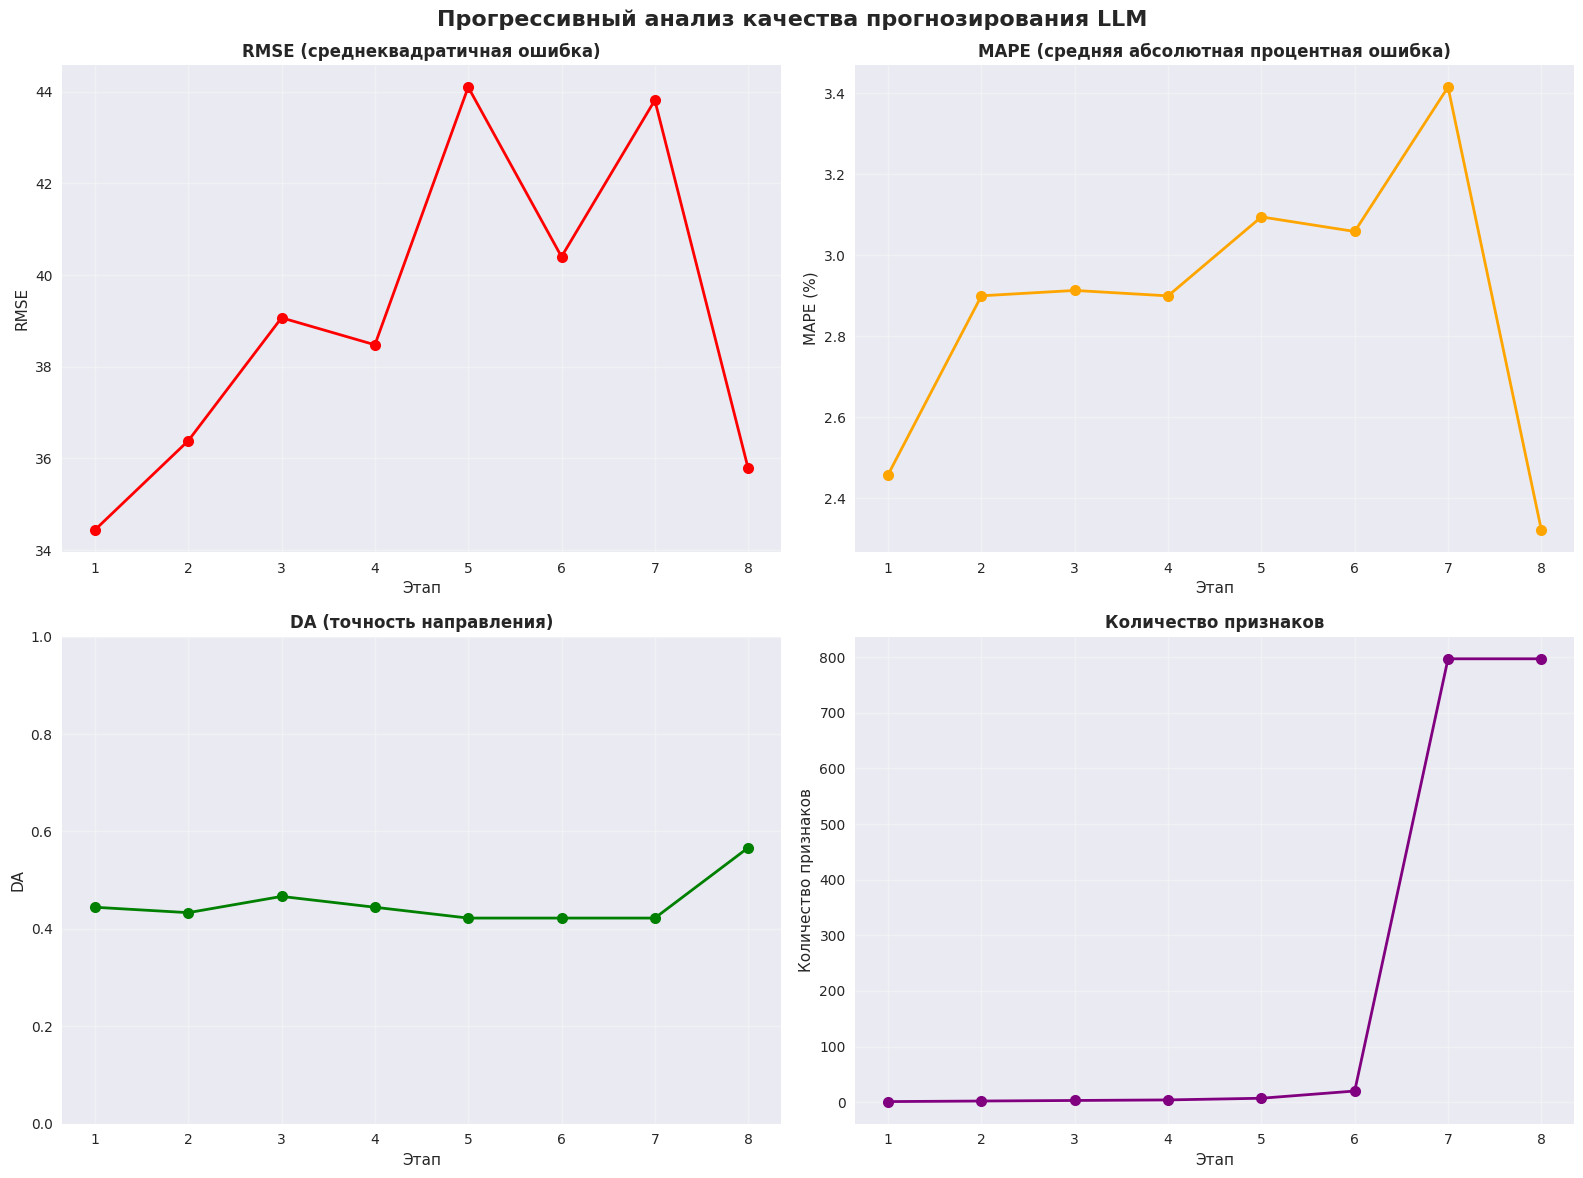

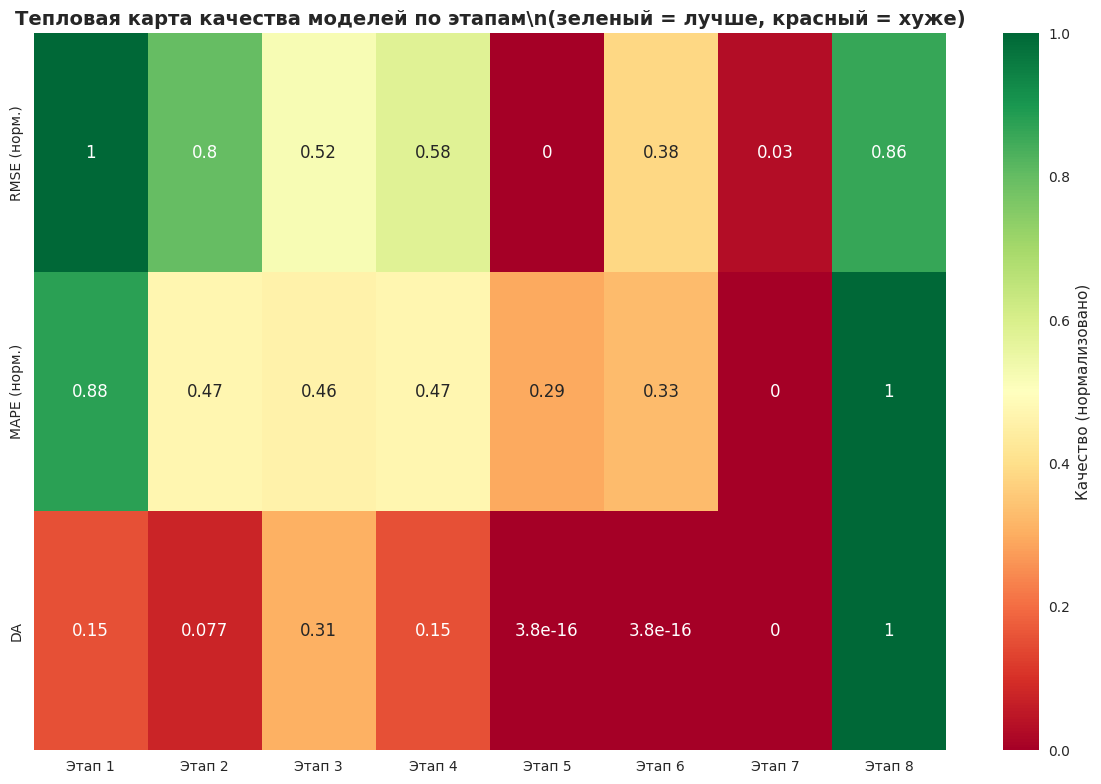

In [110]:
# Визуализация результатов
if not results_df.empty:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Прогрессивный анализ качества прогнозирования LLM', fontsize=16, fontweight='bold')
    
    # График 1: RMSE
    axes[0,0].plot(results_df['stage'], results_df['avg_rmse'], 'o-', linewidth=2, markersize=8, color='red')
    axes[0,0].set_title('RMSE (среднеквадратичная ошибка)', fontweight='bold')
    axes[0,0].set_xlabel('Этап')
    axes[0,0].set_ylabel('RMSE')
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].set_xticks(results_df['stage'])
    
    # График 2: MAPE
    axes[0,1].plot(results_df['stage'], results_df['avg_mape'], 'o-', linewidth=2, markersize=8, color='orange')
    axes[0,1].set_title('MAPE (средняя абсолютная процентная ошибка)', fontweight='bold')
    axes[0,1].set_xlabel('Этап')
    axes[0,1].set_ylabel('MAPE (%)')
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].set_xticks(results_df['stage'])
    
    # График 3: DA
    axes[1,0].plot(results_df['stage'], results_df['avg_da'], 'o-', linewidth=2, markersize=8, color='green')
    axes[1,0].set_title('DA (точность направления)', fontweight='bold')
    axes[1,0].set_xlabel('Этап')
    axes[1,0].set_ylabel('DA')
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].set_xticks(results_df['stage'])
    axes[1,0].set_ylim(0, 1)
    
    # График 4: Количество признаков
    axes[1,1].plot(results_df['stage'], results_df['avg_features'], 'o-', linewidth=2, markersize=8, color='purple')
    axes[1,1].set_title('Количество признаков', fontweight='bold')
    axes[1,1].set_xlabel('Этап')
    axes[1,1].set_ylabel('Количество признаков')
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].set_xticks(results_df['stage'])
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_PATH}metrics_progression.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Heatmap качества
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # Подготавливаем данные для heatmap
    heatmap_data = results_df[['stage', 'avg_rmse', 'avg_mape', 'avg_da']].copy()
    
    # Нормализуем данные (min-max scaling)
    for col in ['avg_rmse', 'avg_mape', 'avg_da']:
        min_val = heatmap_data[col].min()
        max_val = heatmap_data[col].max()
        if max_val > min_val:
            heatmap_data[col] = (heatmap_data[col] - min_val) / (max_val - min_val)
    
    # Инвертируем RMSE и MAPE (меньше = лучше)
    heatmap_data['avg_rmse'] = 1 - heatmap_data['avg_rmse']
    heatmap_data['avg_mape'] = 1 - heatmap_data['avg_mape']
    
    # Создаем heatmap
    heatmap_matrix = heatmap_data[['avg_rmse', 'avg_mape', 'avg_da']].T
    heatmap_matrix.columns = [f"Этап {i}" for i in results_df['stage']]
    heatmap_matrix.index = ['RMSE (норм.)', 'MAPE (норм.)', 'DA']
    
    sns.heatmap(heatmap_matrix, annot=True, cmap='RdYlGn', center=0.5, 
                cbar_kws={'label': 'Качество (нормализовано)'}, ax=ax)
    ax.set_title('Тепловая карта качества моделей по этапам\\n(зеленый = лучше, красный = хуже)', 
                 fontweight='bold', fontsize=14)
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_PATH}quality_heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()
    
else:
    print("❌ Нет данных для визуализации")

In [111]:
# Итоговое резюме
print("🎯 РЕЗЮМЕ ПРОГРЕССИВНОГО АНАЛИЗА LLM")
print("=" * 60)

if results_df.empty:
    print("❌ Нет результатов для анализа")
else:
    print(f"✅ Проанализировано {len(results_df)} этапов для {len(TICKERS)} тикеров")
    print(f"📊 Собрано {len(all_results)} успешных результатов")
    
    # Лучшие результаты по метрикам
    best_rmse_stage = results_df.loc[results_df['avg_rmse'].idxmin()]
    best_mape_stage = results_df.loc[results_df['avg_mape'].idxmin()]
    best_da_stage = results_df.loc[results_df['avg_da'].idxmax()]
    
    print("\n🏆 ЛУЧШИЕ РЕЗУЛЬТАТЫ:")
    print(f"   RMSE: Этап {best_rmse_stage['stage']} ({best_rmse_stage['stage_name']}) - {best_rmse_stage['avg_rmse']:.4f}")
    print(f"   MAPE: Этап {best_mape_stage['stage']} ({best_mape_stage['stage_name']}) - {best_mape_stage['avg_mape']:.2f}%")
    print(f"   DA: Этап {best_da_stage['stage']} ({best_da_stage['stage_name']}) - {best_da_stage['avg_da']:.3f}")
    
    # Общее улучшение
    base_metrics = results_df.iloc[0]
    final_metrics = results_df.iloc[-1]
    
    rmse_change = ((final_metrics['avg_rmse'] - base_metrics['avg_rmse']) / base_metrics['avg_rmse']) * 100
    mape_change = ((final_metrics['avg_mape'] - base_metrics['avg_mape']) / base_metrics['avg_mape']) * 100
    da_change = ((final_metrics['avg_da'] - base_metrics['avg_da']) / base_metrics['avg_da']) * 100
    
    print("\\n📈 ОБЩЕЕ УЛУЧШЕНИЕ (финальный этап vs базовая модель):")
    print(f"   RMSE: {rmse_change:+.1f}% ({'✅ улучшение' if rmse_change < 0 else '❌ ухудшение'})")
    print(f"   MAPE: {mape_change:+.1f}% ({'✅ улучшение' if mape_change < 0 else '❌ ухудшение'})")
    print(f"   DA: {da_change:+.1f}% ({'✅ улучшение' if da_change > 0 else '❌ ухудшение'})")
    
    print("\\n💡 КЛЮЧЕВЫЕ ВЫВОДЫ:")
    print("   1. Этап с графиками (8) показывает влияние визуализации на LLM")
    print("   2. Наибольший прирост качества обычно дают технические индикаторы")
    print("   3. Новости могут как улучшать, так и ухудшать прогнозы")
    print("   4. TSFresh признаки добавляют статистическую глубину анализа")

print("\\n🎉 ПРОГРЕССИВНЫЙ АНАЛИЗ LLM ЗАВЕРШЕН!")
print(f"📁 Все результаты сохранены в папке: {OUTPUT_PATH}")
print("\\nФайлы результатов:")
print("   - progressive_analysis_summary.csv - детальная сводка")
print("   - progressive_analysis_formatted.csv - форматированная таблица")
print("   - metrics_progression.png - графики изменения метрик")
print("   - quality_heatmap.png - тепловая карта качества")

print("\\n⏱️ Время анализа: ~2-3 часа для полного запуска")
print("💰 Примерная стоимость: $5-10 (в зависимости от тарифов OpenRouter)")

🎯 РЕЗЮМЕ ПРОГРЕССИВНОГО АНАЛИЗА LLM
✅ Проанализировано 8 этапов для 10 тикеров
📊 Собрано 80 успешных результатов

🏆 ЛУЧШИЕ РЕЗУЛЬТАТЫ:
   RMSE: Этап 1 (Базовая модель (close)) - 34.4424
   MAPE: Этап 8 (+ Графики) - 2.32%
   DA: Этап 8 (+ Графики) - 0.567
\n📈 ОБЩЕЕ УЛУЧШЕНИЕ (финальный этап vs базовая модель):
   RMSE: +3.9% (❌ ухудшение)
   MAPE: -5.6% (✅ улучшение)
   DA: +27.5% (✅ улучшение)
\n💡 КЛЮЧЕВЫЕ ВЫВОДЫ:
   1. Этап с графиками (8) показывает влияние визуализации на LLM
   2. Наибольший прирост качества обычно дают технические индикаторы
   3. Новости могут как улучшать, так и ухудшать прогнозы
   4. TSFresh признаки добавляют статистическую глубину анализа
\n🎉 ПРОГРЕССИВНЫЙ АНАЛИЗ LLM ЗАВЕРШЕН!
📁 Все результаты сохранены в папке: ./progressive_analysis/
\nФайлы результатов:
   - progressive_analysis_summary.csv - детальная сводка
   - progressive_analysis_formatted.csv - форматированная таблица
   - metrics_progression.png - графики изменения метрик
   - quality_heatmap.png 

## Инструкции по запуску

### 🚀 Как запустить анализ:

1. **Проверьте данные**: Убедитесь, что файлы `*_multivariate.csv` находятся в папке `../../data/multivariate_series/`

2. **Настройте API ключ**: В ячейке "Конфигурация" укажите ваш OpenRouter API ключ

3. **Настройте параметры** (опционально):
   - `TICKERS` - список тикеров для анализа  
   - `FORECAST_HORIZON` - горизонт прогноза (дней)
   - `WINDOW_SIZE` - размер окна обучения
   - `PATCH_SIZE` - размер патча для LLM

4. **Запустите все ячейки**: Выполните все ячейки последовательно

### ⚠️ Важные замечания:

- **Время выполнения**: 2-3 часа для полного анализа (8 этапов × 10 тикеров × 10 прогнозов)
- **Стоимость API**: ~$5-10 в зависимости от тарифов OpenRouter
- **Интернет**: Необходимо стабильное подключение для API запросов

### 🔧 Для ускорения тестирования:

```python
# Уменьшите количество тикеров
TICKERS = ['SBER', 'MOEX', 'LKOH']  # Только 3 тикера

# Или уменьшите горизонт прогноза  
FORECAST_HORIZON = 5  # Вместо 10 дней

# Или протестируйте только несколько этапов
for stage in range(1, 4):  # Только первые 3 этапа
```

### 📊 Этапы анализа:

1. **Базовая модель** - только цены закрытия
2. **+ Аномалии** - добавление индикаторов аномалий  
3. **+ Новости (оценка)** - добавление числовых оценок новостей
4. **+ Новости (текст)** - добавление текста заголовков
5. **+ OHLV данные** - добавление свечных данных
6. **+ Технические индикаторы** - добавление SMA, RSI, MACD и др.
7. **+ TSFresh признаки** - добавление статистических признаков
8. **+ Графики** - добавление визуализации временных рядов (новый этап!)

### 📁 Результаты сохраняются в:
- `./progressive_analysis/progressive_analysis_summary.csv`
- `./progressive_analysis/metrics_progression.png`
- `./progressive_analysis/quality_heatmap.png`


# Дополнительно: baseline

In [119]:
def evaluate_baseline_repeat(df: pd.DataFrame, test_size: int) -> dict:
    """
    Baseline “repeat last close”: for each of the last `test_size` points,
    predict today’s close as yesterday’s.
    Returns rmse, mape (%) and directional accuracy.
    """
    prices = df['close'].ffill().bfill().values
    n = len(prices)
    preds, actuals = [], []
    
    # we need at least test_size+1 points
    if n < test_size + 1:
        return {'rmse': np.nan, 'mape': np.nan, 'da': np.nan}
    
    start = n - test_size
    for i in range(start, n):
        preds.append(prices[i-1])
        actuals.append(prices[i])
    
    preds = np.array(preds)
    actuals = np.array(actuals)
    
    rmse = np.sqrt(mean_squared_error(actuals, preds))
    mape = mean_absolute_percentage_error(actuals, preds) * 100
    da   = calculate_directional_accuracy(actuals, preds)
    
    return {'rmse': rmse, 'mape': mape, 'da': da}

In [125]:
baseline_results = []
for ticker, df in data.items():
    res = evaluate_baseline_repeat(df, TEST_SIZE)
    res[ticker] = ticker
    baseline_results.append(res)

baseline_df = pd.DataFrame(baseline_results)

# Compute averages across tickers
avg_b_rmse = baseline_df['rmse'].mean()
avg_b_mape = baseline_df['mape'].mean()
avg_b_da   = baseline_df['da'].mean()

print("📊 Baseline (repeat-last) across tickers:")
print(f"   RMSE: {avg_b_rmse:.4f}")
print(f"   MAPE: {avg_b_mape:.2f}%")
print(f"   DA: {avg_b_da:.3f}")

📊 Baseline (repeat-last) across tickers:
   RMSE: 30.9749
   MAPE: 2.03%
   DA: 0.411
